Gus Marquez IS687

Captain's OpenCV Object Detection in Video

(Help for these code can be found in OpenCV, YOLO and PYImageSearch)

Google Drive Mounted /content/drive/MyDrive/colab/

LOAD LIBRARIES and SETUP

In [ ]:
pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


SETUP

In [ ]:
import numpy as np
import time
import calendar
import cv2
import imutils
from imutils.video import FPS
from imutils.video import VideoStream

#  Google Drive Paths

INPUT_FILE='/content/drive/MyDrive/colab/traffictiny.mp4'
OUTPUT_FILE='output.avi'
LABELS_FILE='/content/drive/MyDrive/colab/coco.names'
CONFIG_FILE='/content/drive/MyDrive/colab/yolov3.cfg'
WEIGHTS_FILE='/content/drive/MyDrive/colab/yolov3.weights'
CONFIDENCE_THRESHOLD=0.3

#  Set high, width, timer, writer, labels, color, darknet, video capture
#   And all my counters / accumulators
#    (cc) counting counter, (conf) confidence, 
#     Now...  (plot) the value for plotting later and tranfered via drive to ImageAI



# Video Capture abd boxes
H=None
W=None
fourcc = cv2.VideoWriter_fourcc(*"MJPG")
writer = cv2.VideoWriter(OUTPUT_FILE, fourcc, 30,
	(800, 600), True)
LABELS = open(LABELS_FILE).read().strip().split("\n")
# 42, Captain's meaning of life
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")
net = cv2.dnn.readNetFromDarknet(CONFIG_FILE, WEIGHTS_FILE)
vs = cv2.VideoCapture(INPUT_FILE)
ln = [layer_name for layer_name in net.getUnconnectedOutLayersNames()]

# Counters/Accumulators 
cnt =0;
carcc = 0; carconf = 0; carplot = []
personcc = 0; personconf = 0; personplot = []
motorbikecc = 0; motorbikeconf = 0; motorbikeplot = []
truckcc = 0; truckconf = 0; truckplot = []
FRAMENUM = 0
tt = 0


In [ ]:
#SET TIMER
# this timer for CV is the same for AI
current_GMT = time.gmtime()
time_stamp_start = calendar.timegm(current_GMT)
print("Current timestamp:", time_stamp_start)
fps = FPS().start()
# Begin detection/boxes

while True:
	cnt+=1
	print ("Frames so far", cnt)
	try:
		(grabbed, image) = vs.read()
	except:
		break
	blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)

	net.setInput(blob)
	if W is None or H is None:
		(H, W) = image.shape[:2]
	layerOutputs = net.forward(ln)
	if cnt == 102:
		break

	# initialize our lists of detected bounding boxes, confidences, and
	# class IDs, respectively
	boxes = []
	confidences = []
	classIDs = []

	print("#################################################################")
	# LOOPS LAYERS
	for output in layerOutputs:
		#print("OUTPUT >>>>>> ", output)
		# LOOPS DETECTION
		for detection in output:
			#CLASSID / SCORE
			scores = detection[5:]
			classID = np.argmax(scores)
			confidence = scores[classID]
			tt = confidence
			#print("$$$$$$$$$$$$$$$$", FRAMENUM, tt, "$$$$$$$$$$$$$")

			#FILTER
			if confidence > CONFIDENCE_THRESHOLD:
				# BOX
				box = detection[0:4] * np.array([W, H, W, H])
				(centerX, centerY, width, height) = box.astype("int")
				# BOX BOUND
				x = int(centerX - (width / 2))
				y = int(centerY - (height / 2))
				# APPEND
				boxes.append([x, y, int(width), int(height)])
				confidences.append(float(confidence))
				classIDs.append(classID)
		
				#print("$$$$$$$$$$$$$$$$", FRAMENUM, classID, confidence, "$$$$$$$$$$$$$")

	# NMS
	idxs = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE_THRESHOLD,
		CONFIDENCE_THRESHOLD)


	#DETECTION
	if len(idxs) > 0:
		for i in idxs.flatten():
			FRAMENUM = FRAMENUM + 1
			#print("FRAMENUM = :", FRAMENUM)
			#print("IIIIIIIIIII", i)
			# BOX COORDS
			(x, y) = (boxes[i][0], boxes[i][1])
			(w, h) = (boxes[i][2], boxes[i][3])
			#print("$$$$$$$$$$$$$$$$", FRAMENUM, classID, confidence, "$$$$$$$$$$$$$")
			color = [int(c) for c in COLORS[classIDs[i]]]
			cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
			text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
			#print("..........", classIDs[i], "..............TEXT", text)
			cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
				0.5, color, 2)
			#print("TEXT = " , text)
			#CURRENT REPORT...
			#print("This frame", LABELS[classIDs[i]], confidences[i])
	 		# NOW HERE THE COUNTERS/ACCUMULATORS
			if LABELS[classIDs[i]] == "car":
				carcc = carcc + 1
				carconf = carconf + confidences[i]
				carplot.append(confidences[i])
			if LABELS[classIDs[i]] == "person":
				personcc = personcc + 1
				personconf = personconf + confidences[i]
				personplot.append(confidences[i])
			if LABELS[classIDs[i]] == "motorbike":
				motorbikecc = motorbikecc + 1
				motorbikeconf = motorbikeconf + confidences[i]
				motorbikeplot.append(confidences[i])
			if LABELS[classIDs[i]] == "truck":
				truckcc = truckcc + 1
				truckconf = truckconf + confidences[i]
				truckplot.append(confidences[i])
			#print("///////////////////////////Cars = ", carcc, " Confidences = ", carconf)
			#print("CONF = ", confidences[i])

			#print("Persons = ", personcc, " Confidences = ", personconf)
			#print("CONF = ", confidences[i])
	 
			#print("Motorbikes = ", motorbikecc, " Confidences = ", motorbikeconf)
			#print("CONF = ", confidences[i])

			#print("Trucks = ", truckcc, " Confidences = ", truckconf)
			#print("CONF = ", confidences[i])

	#ENDING LOOP LAYEROUTPUT
	#cv2.imshow(cv2.resize(image,(800, 600)))
	writer.write(cv2.resize(image,(800, 600)))
	fps.update()
	#print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
	#print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))
	key = cv2.waitKey(1) & 0xFF
	if key == ord("q"):
		break



#TOTALS........

# TIMER
current_GMT = time.gmtime()
time_stamp_end = calendar.timegm(current_GMT)
print("Start:", time_stamp_start)
print("End:", time_stamp_end)
print("Time:", time_stamp_end - time_stamp_start)


fps.stop()

# REPORTS

print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

print("Cars = ", carcc, " Confidences = ", carconf, " Cars average confidence = " , carconf/carcc)

print("Persons = ", personcc, " Confidences = ", personconf, " Persons average confidence = " , personconf/personcc)

print("Motorbikes = ", motorbikecc, " Confidences = ", motorbikeconf, " Motobikes average confidence = " , motorbikeconf/motorbikecc)

print("Trucks = ", truckcc, " Confidences = ", truckconf, " Trucks average confidence = " , truckconf/truckcc)

# do a bit of cleanup
cv2.destroyAllWindows()

# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()

Current timestamp: 1662672972
Frames so far 1
#################################################################
Frames so far 2
#################################################################
Frames so far 3
#################################################################
Frames so far 4
#################################################################
Frames so far 5
#################################################################
Frames so far 6
#################################################################
Frames so far 7
#################################################################
Frames so far 8
#################################################################
Frames so far 9
#################################################################
Frames so far 10
#################################################################
Frames so far 11
#################################################################
Frames so far 12
#################################################

{'Cars': 0.84349389964804, 'Persons': 0.7554108932057851, 'Motobikes': 0.8441710971451348, 'Trucks': 0.6445973103696649}



<BarContainer object of 4 artists>

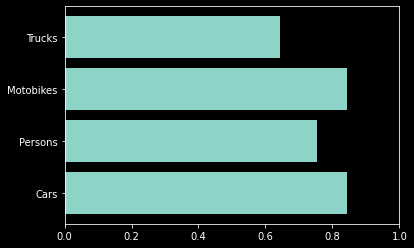

In [ ]:


# PLOT SCORES RESULTS

import matplotlib.pyplot as plt
import numpy as np
plt.style.use('dark_background')

xkeys = ['Cars', 'Persons', 'Motobikes', 'Trucks']
xvalues = [carconf/carcc, personconf/personcc, motorbikeconf/motorbikecc, truckconf/truckcc]
xd = dict(zip(xkeys, xvalues))
print(xd)
print()



group_data = list(xd.values())
group_names = list(xd.keys())
group_mean = np.mean(group_data)

fig, ax = plt.subplots()
ax.set_xlim([0,1])
ax.barh(group_names, group_data)

In [ ]:
print(truckconf)

35.45285207033157


In [ ]:

#  This part transfer save to be load via drive in ImageAI notebook

from matplotlib import docstring
import numpy as np 
co = carplot # create an array of 1000 1's for the example 
po = personplot
mo = motorbikeplot
to = truckplot
xv = xvalues

np.save('/content/drive/MyDrive/colab/cocv', co)

np.save('/content/drive/MyDrive/colab/pocv', po)
        
np.save('/content/drive/MyDrive/colab/mocv', mo)
        
np.save('/content/drive/MyDrive/colab/tocv', to)

np.save('/content/drive/MyDrive/colab/var/xv01cv', xv)
 

In [ ]:
print(xv)

[0.84349389964804, 0.7554108932057851, 0.8441710971451348, 0.6445973103696649]


In [ ]:
# FOR TEST ONLY

ci = np.load('/content/drive/MyDrive/colab/co.npy') 
print(ci)

[0.99773782 0.9943735  0.9893496  ... 0.87632495 0.86970335 0.81949931]


In [ ]:
#Tranfer timestamp to ImageAI

trans_time = time_stamp_end - time_stamp_start
file = open("/content/drive/MyDrive/colab/var/transtime01cv.txt", "w")
str = repr(trans_time)
file.write(str)
file.close()


 
